In [110]:
import pandas as pd
from sklearn.impute import KNNImputer
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [111]:
SEED = 2004
Z_THRESHOLD = 3
N_COMPONENT=2

In [112]:
df = pd.read_csv('datasets/clv_data.csv')

In [113]:
df = df.drop(columns=['Unnamed: 0', 'id'])
df

,age,gender,income,days_on_platform,city,purchases
0,NaN,Male,126895,14.0,San Francisco,0
1,NaN,Male,161474,14.0,Tokyo,0
2,24.0,Male,104723,34.0,London,1
3,29.0,Male,43791,28.0,London,2
4,18.0,Female,132181,26.0,London,2
...,...,...,...,...,...,...
4995,NaN,Female,212261,28.0,San Francisco,1
4996,NaN,Male,70228,12.0,San Francisco,0
4997,NaN,Male,64995,14.0,New York City,0
4998,NaN,Male,56144,4.0,New York City,2


In [114]:
print("Пропуски до заполнения медианой в столбце days_on_platform:")
print(df["days_on_platform"].isnull().sum(), end="\n\n")

df["days_on_platform"] = df["days_on_platform"].fillna(df["days_on_platform"].median(numeric_only=True))

print("Пропуски после заполнения медианой в столбце days_on_platform:")
print(df["days_on_platform"].isnull().sum())

Пропуски до заполнения медианой в столбце days_on_platform:
141

Пропуски после заполнения медианой в столбце days_on_platform:
0


In [115]:
numeric_df = df.select_dtypes(include=["float64", "int64"])

print(f"Пропуски до заполнения KNN в столбце age:")
print(numeric_df["age"].isnull().sum(), end="\n\n")

imputer = KNNImputer(n_neighbors=5)

df["age"] = imputer.fit_transform(numeric_df)[
    :, df.columns.get_loc("age")
]

print(f"Пропуски после заполнения KNN в столбце age:")
print(df["age"].isnull().sum())

Пропуски до заполнения KNN в столбце age:
2446

Пропуски после заполнения KNN в столбце age:
0


In [116]:
df

,age,gender,income,days_on_platform,city,purchases
0,24.6,Male,126895,14.0,San Francisco,0
1,28.2,Male,161474,14.0,Tokyo,0
2,24.0,Male,104723,34.0,London,1
3,29.0,Male,43791,28.0,London,2
4,18.0,Female,132181,26.0,London,2
...,...,...,...,...,...,...
4995,33.4,Female,212261,28.0,San Francisco,1
4996,32.2,Male,70228,12.0,San Francisco,0
4997,22.2,Male,64995,14.0,New York City,0
4998,28.0,Male,56144,4.0,New York City,2


In [117]:
df["income"].describe()

count      5000.000000
mean      79593.336200
std       60304.056095
min           4.000000
25%       32752.500000
50%       65989.000000
75%      115406.500000
max      388572.000000
Name: income, dtype: float64

## IQR метод

In [118]:
col = "income"
Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3 - Q1

print("IQR:", IQR)

IQR: 82654.0


In [119]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print("Границы:", lower_bound, upper_bound)

Границы: -91228.5 239387.5


In [120]:
outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

In [121]:
print("Количество выбросов:", len(outliers))

print("Выбросы:", outliers[col])

Количество выбросов: 77
Выбросы: 50      255965
96      279792
200     309902
249     265599
423     263840
         ...  
4198    273579
4383    308439
4723    264791
4778    282909
4859    299191
Name: income, Length: 77, dtype: int64


## Z-оценка

In [122]:
mean = df[col].mean()
std = df[col].std()

df["z_score_1"] = (df[col] - mean) / std

outliers_z = df[np.abs(df["z_score_1"]) > Z_THRESHOLD]

print("Количество выбросов:", len(outliers_z))
print("Выбросы:")
print(outliers_z[[col, "z_score_1"]])

Количество выбросов: 41
Выбросы:
      income  z_score_1
96    279792   3.319821
200   309902   3.819124
249   265599   3.084464
423   263840   3.055295
455   372813   4.862354
621   263497   3.049607
816   317779   3.949745
838   324518   4.061496
944   364025   4.716626
1145  366344   4.755081
1217  276225   3.260671
1241  285344   3.411888
1386  290833   3.502910
1568  388572   5.123680
1606  288203   3.459297
1676  293214   3.542393
1822  278681   3.301398
1943  273899   3.222099
2006  274687   3.235167
2011  297725   3.617197
2126  294759   3.568013
2502  338053   4.285942
2597  277639   3.284118
2715  307492   3.779160
2883  275810   3.253789
3153  269801   3.154144
3221  370679   4.826967
3484  269725   3.152884
3541  269133   3.143067
3549  268771   3.137064
3581  270813   3.170925
3743  272192   3.193793
3747  269722   3.152834
3843  301032   3.672036
3912  262761   3.037402
3944  349217   4.471070
4198  273579   3.216793
4383  308439   3.794864
4723  264791   3.071065
4778  2

In [123]:
df["z_score_2"] = np.abs(stats.zscore(df[col]))
outliers_z = df[np.abs(df["z_score_2"]) > Z_THRESHOLD]

print("Количество выбросов:", len(outliers_z))
print("Выбросы:")
print(outliers_z[[col, "z_score_1"]])

Количество выбросов: 41
Выбросы:
      income  z_score_1
96    279792   3.319821
200   309902   3.819124
249   265599   3.084464
423   263840   3.055295
455   372813   4.862354
621   263497   3.049607
816   317779   3.949745
838   324518   4.061496
944   364025   4.716626
1145  366344   4.755081
1217  276225   3.260671
1241  285344   3.411888
1386  290833   3.502910
1568  388572   5.123680
1606  288203   3.459297
1676  293214   3.542393
1822  278681   3.301398
1943  273899   3.222099
2006  274687   3.235167
2011  297725   3.617197
2126  294759   3.568013
2502  338053   4.285942
2597  277639   3.284118
2715  307492   3.779160
2883  275810   3.253789
3153  269801   3.154144
3221  370679   4.826967
3484  269725   3.152884
3541  269133   3.143067
3549  268771   3.137064
3581  270813   3.170925
3743  272192   3.193793
3747  269722   3.152834
3843  301032   3.672036
3912  262761   3.037402
3944  349217   4.471070
4198  273579   3.216793
4383  308439   3.794864
4723  264791   3.071065
4778  2

## PCA очистка

In [124]:
X = df.select_dtypes(include=["float64", "int64"])

In [125]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [126]:
pca = PCA(n_components=N_COMPONENT)
X_pca = pca.fit_transform(X_scaled)

In [127]:
X_reconstructed = pca.inverse_transform(X_pca)

In [128]:
reconstruction_error = np.mean((X_scaled - X_reconstructed) ** 2, axis=1)

In [129]:
df["reconstruction_error"] = reconstruction_error

In [130]:
threshold = df["reconstruction_error"].mean() + 3 * df["reconstruction_error"].std()

In [131]:
outliers_pca = df[df["reconstruction_error"] > threshold]

print("Количество выбросов по PCA:", len(outliers_pca))
print("Порог ошибки:", threshold)

print(outliers_pca[[col, "reconstruction_error"]])

Количество выбросов по PCA: 110
Порог ошибки: 1.6091280693753607
      income  reconstruction_error
43     52145              1.627596
47      9866              1.904161
74     39736              1.713837
104    24491              1.873688
117      756              2.203460
...      ...                   ...
4739   88817              1.784008
4841  148827              1.771898
4947   78264              3.065078
4958   79452              2.607090
4990    3020              1.675228

[110 rows x 2 columns]


In [132]:
df_removed = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

print("Размер датасета до удаления:", len(df))
print("Размер датасета после удаления:", len(df_removed))

Размер датасета до удаления: 5000
Размер датасета после удаления: 4923


Text(0.5, 1.0, 'Boxplot после обработки')

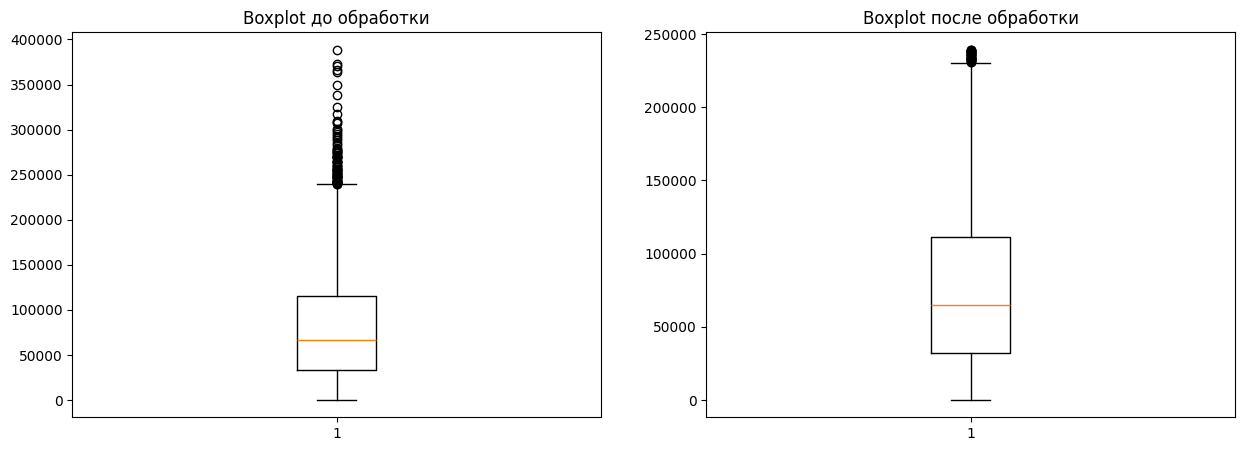

In [133]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.boxplot(df[col])
ax1.set_title("Boxplot до обработки")

ax2.boxplot(df_removed[col])
ax2.set_title("Boxplot после обработки")

## PCA отбор

In [134]:
data_encoded = pd.get_dummies(df_removed, drop_first=True)

In [135]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_encoded)

In [136]:
pca = PCA(n_components=N_COMPONENT)
pca_data = pca.fit_transform(scaled_data)

In [137]:
pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])
print("Доля объяснённой дисперсии:", pca.explained_variance_ratio_)
print("\nКомпоненты PCA:\n", pd.DataFrame(pca.components_, columns=data_encoded.columns))

print("\nPCA-таблица:")
print(pca_df)

Доля объяснённой дисперсии: [0.18488149 0.12462499]

Компоненты PCA:
         age    income  days_on_platform  purchases  z_score_1  z_score_2  \
0  0.044629  0.647997         -0.047795  -0.035355   0.647997   0.369908   
1  0.004876  0.081410          0.493464   0.486208   0.081410   0.068441   

   reconstruction_error  gender_Male  city_Miami  city_New York City  \
0             -0.132339    -0.009263   -0.006146            0.013136   
1              0.679499     0.057892    0.133768            0.017869   

   city_San Francisco  city_Tokyo  
0           -0.000852   -0.005629  
1           -0.019830   -0.135848  

PCA-таблица:
           PC1       PC2
0     1.264773 -0.816120
1     2.517987 -1.084296
2     0.423929 -0.038369
3    -0.814374 -0.208171
4     1.399850  0.031805
...        ...       ...
4918  4.338751 -0.086804
4919 -0.479623 -1.053757
4920 -0.567112 -0.865205
4921 -0.599626 -0.710284
4922  0.816714 -0.850249

[4923 rows x 2 columns]
